In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

  Created wheel for mendelai-brat-parser: filename=mendelai_brat_parser-0.0.11-py3-none-any.whl size=4945 sha256=12a7ca1863d57ac7713e5ff1a93d819dc1faa7b176d23438a55efe4997b44f07
  Stored in directory: /root/.cache/pip/wheels/7e/40/73/4f68f4fa597be33e250400cd56c28c85862b1cba5b3c7c33f1
Successfully built mendelai-brat-parser
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
from collections import Counter
import math

from google.colab import files
import zipfile
import glob

from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Neural network imports.
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input, Dropout
from keras.layers import TimeDistributed
from keras.layers import Concatenate
from keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input

# **Relations Dataframes**

In [ ]:
# Import the datataset, created in a previous moment, (essay_relation_dataset.csv) 
# containing an entry for each relation of the Stab and Gurevych dataset.
# Each entry is composed as: 
# (type,doc_id,supporting_text,supporting_type,supporting_sentence_id,supporting_section_length,supported_text,supported_type,supported_sentence_id,supported_section_length)
# where type is the relation tipe (attack, support, none).
# supporting and supported refer to the two section of the corpus that are in a relation:
# text refers to their original texts, type if they are a premise or a claim, the length to the number of sentences in the arg. section after the first one,  and sentence_id
# indicates the position in the corpus of the sentence that contains them.
print('\nImport essay_relation_dataset.csv\n')
uploaded = files.upload()


Import essay_relation_dataset.csv



Saving essay_relation_dataset.csv to essay_relation_dataset.csv


In [ ]:
# Import the datataset created in a previous moment (microtext_relation_dataset.csv) 
# containing an entry for each relation of the arg-microtext dataset.
# Each entry is composed as: 
# (doc_id,supporting_text,supporting_sentence_id,supporting_section_length,supported_text,supported_sentence_id,supported_section_length)
# where type is the relation tipe (attack, support, none).
# supporting and supported refer to the two section of the corpus that are in a relation:
# text refers to their original texts, the length to the number of sentences in the arg. section after the first one,  and sentence_id
# indicates the position in the corpus of the sentence that contains them.
print('\nImport microtext_relation_dataset.csv\n')
uploaded = files.upload()


Import microtext_relation_dataset.csv



Saving microtext_relation_dataset.csv to microtext_relation_dataset.csv


In [ ]:
# The imported dataset is here directly used.

microtext_relation_ann_dataset=pd.read_csv('microtext_relation_dataset.csv')

In [ ]:
microtext_relation_ann_dataset.head()

,type,doc_id,supporting_text,supporting_sentence_id,supported_text,supported_sentence_id
0,attacks,0,"Yes, it's annoying and cumbersome to separate ...",0,We Berliners should take the chance and become...,3
1,supports,0,Three different bin bags stink away in the kit...,1,"Yes, it's annoying and cumbersome to separate ...",0
2,supports,1,One can hardly move in Friedrichshain or Neukö...,4,Higher fines are therefore the right measure a...,6
3,supports,1,And when bad luck does strike and you step int...,5,Higher fines are therefore the right measure a...,6
4,attacks,1,"Of course, first they'd actually need to be ca...",7,Higher fines are therefore the right measure a...,6


In [ ]:
number_documents=len(list(set(microtext_relation_ann_dataset['doc_id'].tolist())))

In [ ]:
# The imported dataset is here directly used.
# MajorClaim have been removed from the argumentations in the imported dataset (they don't have labeled relations).

relation_ann_dataset=pd.read_csv('essay_relation_dataset.csv')

relation_ann_dataset=relation_ann_dataset.drop(['supporting_type', 'supported_type'], axis=1)

In [ ]:
relation_ann_dataset.head()

,type,doc_id,supporting_text,supporting_sentence_id,supporting_section_length,supported_text,supported_sentence_id,supported_section_length
0,supports,0,What we acquired from team work is not only ho...,5,0,"through cooperation, children can learn about ...",4,0
1,supports,0,"During the process of cooperation, children ca...",6,0,"through cooperation, children can learn about ...",4,0
2,supports,0,All of these skills help them to get on well w...,7,0,"through cooperation, children can learn about ...",4,0
3,supports,0,the significance of competition is that how to...,8,0,competition makes the society more effective,9,0
4,supports,0,when we consider about the question that how t...,10,0,"without the cooperation, there would be no vic...",14,0


# **Select the sections to classify and the labels**

In [ ]:
# Get the list of the words of each argumentative section that is part of a 
# relation.

X_supporting_section_list=[]
X_supported_section_list=[]

for relation in relation_ann_dataset.itertuples():

  supporting=""
  supported=""

  supporting_sequence=relation.supporting_text
  supported_sequence=relation.supported_text

  # Divide the sections into token.
  supporting_seq_word=nltk.word_tokenize(supporting_sequence.lower())
  supported_seq_word=nltk.word_tokenize(supported_sequence.lower())

  for word in supporting_seq_word:
    supporting+=word+" "

  for word in supported_seq_word:
    supported+=word+" "

  X_supporting_section_list.append(supporting)
  X_supported_section_list.append(supported) 

In [ ]:
# Get the list of the words of each argumentative section that is part of a 
# relation.

X_microtext_supporting_section_list=[]
X_microtext_supported_section_list=[]

for relation in microtext_relation_ann_dataset.itertuples():

  supporting=""
  supported=""

  supporting_sequence=relation.supporting_text
  supported_sequence=relation.supported_text

  # Divide the sections into token.
  supporting_seq_word=nltk.word_tokenize(supporting_sequence.lower())
  supported_seq_word=nltk.word_tokenize(supported_sequence.lower())

  for word in supporting_seq_word:
    supporting+=word+" "

  for word in supported_seq_word:
    supported+=word+" "

  X_microtext_supporting_section_list.append(supporting)
  X_microtext_supported_section_list.append(supported) 

In [ ]:
X_supporting_section_list[:5]

['what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 'all of these skills help them to get on well with other people and will benefit them for the whole life ',
 'the significance of competition is that how to become more excellence to gain the victory ',
 'when we consider about the question that how to win the game , we always find that we need the cooperation ']

In [ ]:
X_supported_section_list[:5]

['through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'competition makes the society more effective ',
 'without the cooperation , there would be no victory of competition ']

In [ ]:
X_microtext_supporting_section_list[:5]

["yes , it 's annoying and cumbersome to separate your rubbish properly all the time . ",
 'three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins . ',
 'one can hardly move in friedrichshain or neukölln these days without permanently scanning the ground for dog dirt . ',
 "and when bad luck does strike and you step into one of the many 'land mines ' you have to painstakingly scrape the remains off your soles . ",
 "of course , first they 'd actually need to be caught in the act by public order officers , "]

In [ ]:
X_microtext_supported_section_list[:5]

['we berliners should take the chance and become pioneers in waste separation ! ',
 "yes , it 's annoying and cumbersome to separate your rubbish properly all the time . ",
 'higher fines are therefore the right measure against negligent , lazy or simply thoughtless dog owners . ',
 'higher fines are therefore the right measure against negligent , lazy or simply thoughtless dog owners . ',
 'higher fines are therefore the right measure against negligent , lazy or simply thoughtless dog owners . ']

In [ ]:
X_supported_word_list=[nltk.word_tokenize(section) for section in X_supported_section_list]
X_supporting_word_list=[nltk.word_tokenize(section) for section in X_supporting_section_list]
X_microtext_supported_word_list=[nltk.word_tokenize(section) for section in X_microtext_supported_section_list]
X_microtext_supporting_word_list=[nltk.word_tokenize(section) for section in X_microtext_supporting_section_list]

In [ ]:
Y_relation_type=microtext_relation_ann_dataset["type"].tolist()

Y_relation_type[:10]

['attacks',
 'supports',
 'supports',
 'supports',
 'attacks',
 'attacks',
 'attacks',
 'attacks',
 'attacks',
 'attacks']

In [ ]:
Y_relation_type_temp=[]

for rel in Y_relation_type:
  if rel=="supports":
    Y_relation_type_temp.append(1)
  else:
    if rel=="None":
      Y_relation_type_temp.append(0)
    else:
      Y_relation_type_temp.append(2)

Y_microtext_relation_type=Y_relation_type_temp

Y_microtext_relation_type[:10]

[2, 1, 1, 1, 2, 2, 2, 2, 2, 2]

In [ ]:
Y_relation_type=relation_ann_dataset["type"].tolist()

Y_relation_type[:10]

['supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'None']

In [ ]:
Y_relation_type_temp=[]

for rel in Y_relation_type:
  if rel=="supports":
    Y_relation_type_temp.append(1)
  else:
    if rel=="None":
      Y_relation_type_temp.append(0)
    else:
      Y_relation_type_temp.append(2)

Y_relation_type=Y_relation_type_temp

Y_relation_type[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [ ]:
Y_relation_type=Y_relation_type+Y_microtext_relation_type

In [ ]:
# Definition of the class weights to reduce the impact of the imbalance in the dataset.
class_weights={0: 1, 1: 1, 2:8}

# **Word2vec and one-hot-encoding**

In [ ]:
import gensim
import gensim.downloader as api

path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# Get the maximum lenght of the argumentative sections of the essays.

text_len = [len(text) for text in X_supporting_word_list+X_microtext_supporting_word_list]
MAX_LEN_SUPPORTING = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING))

text_len = [len(text) for text in X_supported_word_list+X_microtext_supported_word_list]
MAX_LEN_SUPPORTED = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED))

Max lenght of the supporting argumentative sections: 72
Max lenght of the supporting argumentative sections: 50


In [ ]:
text_tokenizer_supporting = Tokenizer()
text_tokenizer_supporting.fit_on_texts(X_supporting_word_list+X_microtext_supporting_word_list)
X_supporting = text_tokenizer_supporting.texts_to_sequences(X_supporting_word_list+X_microtext_supporting_word_list)
X_supporting = pad_sequences(X_supporting, maxlen=MAX_LEN_SUPPORTING, padding="pre")

text_tokenizer_supported = Tokenizer()
text_tokenizer_supported.fit_on_texts(X_supported_word_list+X_microtext_supported_word_list)
X_supported = text_tokenizer_supported.texts_to_sequences(X_supported_word_list+X_microtext_supported_word_list)
X_supported = pad_sequences(X_supported, maxlen=MAX_LEN_SUPPORTED, padding="pre")

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300
EMBEDDING_SIZE  = 300

# Size of the vocabulary used
VOCABULARY_SIZE_SUPPORTING = len(text_tokenizer_supporting.word_index) + 1
VOCABULARY_SIZE_SUPPORTED = len(text_tokenizer_supported.word_index) + 1

# Create an empty embedding matix
embedding_weights_supporting = np.zeros((VOCABULARY_SIZE_SUPPORTING, EMBEDDING_SIZE))
embedding_weights_supported = np.zeros((VOCABULARY_SIZE_SUPPORTED, EMBEDDING_SIZE))

# Create a word to index dictionary mapping
word2id_supporting = text_tokenizer_supporting.word_index
word2id_supported = text_tokenizer_supported.word_index

# Copy vectors from word2vec model to the words present in corpus
for word, index in word2id_supporting.items():
    try:
        embedding_weights_supporting[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported.items():
    try:
        embedding_weights_supported[index, :] = word2vec_model[word]
    except KeyError:
        print(word)        

to
,
and
of
a
's
.
'
;
’
``
''
part-time
(
)
:
his/her
-
15
face-to-face
co-worker
e-mail
high-tech
toefl
“
co-operative
penalty-kick
dish-washing
!
centre
well-being
learnt
30
long-time
travelling
40
multiple-choice
20
non-environmentally
he/she
?
morning-after
co-tenant
10
2008
co-operation
state-of-the-art
–
well-rounded
well-trained
--
labelled
100
off-campus
comities
behaviour
environmentally-friendly
well-paid
devoiding
white-collar
team-working
artcrafts
e-learning
re-plays
self-independence
short-sighted
indira
89
cutting-edge
archuleta
high-quality
2003
test-takers
ibt
face-to
clear-cut
'halo
cutting-edged
group-studying
non-renewable
un-recyclable
co-workers
politian
indonesians
4:00
twenty-four
20th
sugesstions
foxconn
self-control
theoritical
top-level
to-do
trivials
high-ranking
burn-out
justing
british-ruled
behaviours
mncs
tradition-related
defence
programmes
non-globalized
”
‘
ivory-tower
one-third
gorvernment
1960
falseful
2010
enthuasism
garther
occupation-related
sho

# **Split Train and Test set**

In [ ]:
# Create a list of values between 0 and 401, where each value indicate an essay
# in the corpus.

essay_id_list=[i for i in range(402)]

microtext_id_list=[i for i in range(number_documents)]

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
train_set,test_set=train_test_split(essay_id_list,test_size=0.15,random_state=42)

microtext_test_set=microtext_id_list
microtext_train_set=[]

In [ ]:
print(len(microtext_train_set))

microtext_train_set[:10]

0


[]

In [ ]:
print(len(microtext_test_set))

microtext_test_set[:10]

112


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
X_argumentative_sections_doc=list(relation_ann_dataset['doc_id'])

len_skip=len(X_argumentative_sections_doc)

sections_train_set=[]
sections_test_microtext_set=[]
sections_test_set=[]

for i in range(len(X_argumentative_sections_doc)):
  if X_argumentative_sections_doc[i] in test_set:
    sections_test_set.append(i)
  else:
    sections_train_set.append(i)

X_argumentative_sections_doc=list(microtext_relation_ann_dataset['doc_id'])    

for i in range(len(X_argumentative_sections_doc)):
  if X_argumentative_sections_doc[i] in microtext_test_set:
    sections_test_microtext_set.append(i+len_skip)
  else:
    sections_train_set.append(i+len_skip)    

# **RNN**

In [ ]:
# Create and train recurrent models.

def train_supporting_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING, weights= [embedding_weights_supporting], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Bidirectional LSTM model for the section preceding the argomentative ones.

def train_supported_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED, weights= [embedding_weights_supported], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Multimodal model.

def train_MultiModal(X_supporting_train:np.array, X_supported_train:np.array, Y_train:np.ndarray)->Model:

  # Create the others models.
  model_supporting,input_supporting=train_supporting_model(X_supporting_train)
  model_supported,input_supported=train_supported_model(X_supported_train)

  # Concatenate togheter the previous NN.
  concatenation_layer = Concatenate()([model_supporting,model_supported])

  output = Dense(3, activation='softmax')(concatenation_layer)

  final_model=Model([input_supporting,input_supported],output)

  final_model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit([X_supporting_train,X_supported_train], Y_train, batch_size=64, class_weight=class_weights, epochs=50, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=2),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model

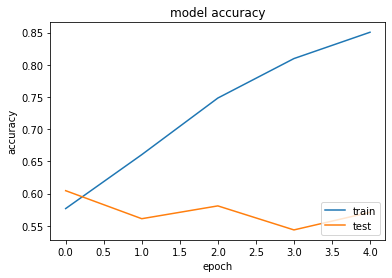

In [ ]:
target_names=['None','Support','Attack']
 
y_pred=[]
y_true=[]

# Assign one-hot encodings to Y values (0,1,2).
categorical_Y = to_categorical(Y_relation_type)

X_supporting_train, X_supporting_test, X_supporting_microtext_test  = X_supporting[sections_train_set], X_supporting[sections_test_set], X_supporting[sections_test_microtext_set]
X_supported_train, X_supported_test, X_supported_microtext_test  = X_supported[sections_train_set], X_supported[sections_test_set], X_supported[sections_test_microtext_set]
Y_train, Y_test, Y_microtext_test = categorical_Y[sections_train_set], categorical_Y[sections_test_set], categorical_Y[sections_test_microtext_set]

# Train the model.
model=train_MultiModal(X_supporting_train,X_supported_train,Y_train)

y_pred_temp=model.predict([X_supporting_microtext_test,X_supported_microtext_test])
for i in range(len(Y_microtext_test)):
  y_pred.append(np.argmax(y_pred_temp[i]))
  y_true.append(np.argmax(Y_microtext_test[i].tolist()))

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

              precision    recall  f1-score   support

        None       0.00      0.00      0.00         0
     Support       0.71      0.54      0.62       263
      Attack       0.30      0.06      0.09       108

    accuracy                           0.40       371
   macro avg       0.34      0.20      0.24       371
weighted avg       0.59      0.40      0.46       371



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


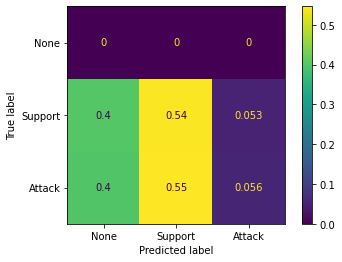

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()

## **Stab and Gurevych test set**

In [ ]:
y_pred=[]
y_true=[]

y_pred_temp=model.predict([X_supporting_test,X_supported_test])
for i in range(len(Y_test)):
  y_pred.append(np.argmax(y_pred_temp[i]))
  y_true.append(np.argmax(Y_test[i].tolist()))

# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        None       0.46      0.48      0.47       319
     Support       0.67      0.67      0.67       542
      Attack       0.06      0.04      0.05        28

    accuracy                           0.58       889
   macro avg       0.40      0.39      0.39       889
weighted avg       0.58      0.58      0.58       889



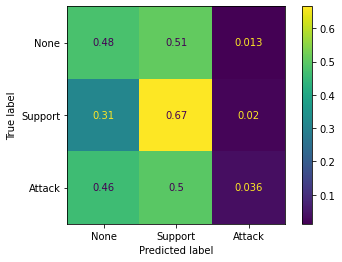

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()